<a href="https://colab.research.google.com/github/AbhimanyuAryan/Deep_Learning_Computer_Vision/blob/master/minibatch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
from torch.nn import init

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [0]:
from torch import optim

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
lr = 0.5
epochs = 1

In [111]:
n, m = x_train.shape
n, m

(50000, 784)

In [112]:
c = y_train.max() + 1
nh = 50
c, nh

(tensor(10), 50)

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [0]:
model = Model(m, nh, 10)
pred = model(x_train)

In [115]:
pred

tensor([[-0.0736,  0.0601,  0.1036,  ...,  0.2558, -0.1536, -0.0219],
        [-0.1011,  0.2053,  0.0425,  ...,  0.2475, -0.1255, -0.0501],
        [-0.0418,  0.0647,  0.0314,  ...,  0.1180, -0.1298, -0.0646],
        ...,
        [-0.0535,  0.1196,  0.0883,  ...,  0.2302, -0.0802, -0.1175],
        [-0.0209,  0.0420,  0.1311,  ...,  0.2470, -0.0940, -0.0902],
        [-0.0583,  0.0804,  0.0651,  ...,  0.1990, -0.1237, -0.0287]],
       grad_fn=<AddmmBackward>)

# Cross Entropy

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or in better maths/words ------------------->

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$

In [0]:
def log_softmax(x): return (x.exp()/ (x.exp().sum(-1, keepdim=True))).log()

In [0]:
sm_pred = log_softmax(pred)

In [118]:
sm_pred

tensor([[-2.3737, -2.2401, -2.1965,  ..., -2.0444, -2.4538, -2.3221],
        [-2.4182, -2.1118, -2.2746,  ..., -2.0697, -2.4426, -2.3673],
        [-2.3194, -2.2129, -2.2462,  ..., -2.1596, -2.4074, -2.3421],
        ...,
        [-2.3641, -2.1910, -2.2223,  ..., -2.0804, -2.3908, -2.4282],
        [-2.3267, -2.2638, -2.1747,  ..., -2.0588, -2.3998, -2.3960],
        [-2.3464, -2.2078, -2.2231,  ..., -2.0891, -2.4119, -2.3168]],
       grad_fn=<LogBackward>)

### So we want to see probability associated with y_train in our sm_pred 

In [119]:
y_train[0]

tensor(5)

In [120]:
# we have 50k numbers have so predictions are also 50k with size 10...which are 
# probabilities associated
# with y_train number with respect to all the numbers given in the set 0-9
sm_pred.shape

torch.Size([50000, 10])

In [121]:
# check at 5th position....
sm_pred[0], y_train[0]

(tensor([-2.3737, -2.2401, -2.1965, -2.4745, -2.3991, -2.1813, -2.4323, -2.0444,
         -2.4538, -2.3221], grad_fn=<SelectBackward>), tensor(5))

In [122]:
y_train.shape[0]

50000

In [123]:
sm_pred[range(50000), y_train]

tensor([-2.1813, -2.4182, -2.3592,  ..., -2.3908, -2.3374, -2.4119],
       grad_fn=<IndexBackward>)

In [124]:
sm_pred[range(2), [5,0]] # so basically we are grabbing tensor positions at 5 & 0 from log_softmax output

tensor([-2.1813, -2.4182], grad_fn=<IndexBackward>)

In [0]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [0]:
loss = nll(sm_pred, y_train)

In [127]:
loss

tensor(2.3302, grad_fn=<NegBackward>)

image.png

In [0]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [129]:
nll(log_softmax(pred), y_train)

tensor(2.3302, grad_fn=<NegBackward>)

In [0]:
from torch.functional import F

In [0]:
loss_func = F.cross_entropy

# *Accuracy*

In [0]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [0]:
bs = 64

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs + 1):
    start_i = i*bs
    end_i = start_i + bs
    # getting batch from data
    xb = x_train[start_i: end_i]
    yb = y_train[start_i: end_i]
    loss = loss_func(model(xb), yb)

    loss.backward() # backward does x.grad += dloss/dx https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

In [135]:
(n-1) / bs + 1

782.234375

In [136]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1444, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
pred = model(xb)

In [138]:
y_train[0]

tensor(5)

In [0]:
prob_pred = log_softmax(pred)

In [0]:
#prob_pred[range(50000), y_train[:3]]

In [141]:
prob_pred[0]

tensor([-1.0564e+01, -1.5190e+01, -1.2003e+01, -1.1302e+01, -5.3372e+00,
        -1.1736e+01, -1.3357e+01, -6.9553e+00, -8.3337e+00, -6.0759e-03],
       grad_fn=<SelectBackward>)

In [0]:
#nll(prob_pred, y_train)

## Using parameters and optim

In [0]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)
  
  def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

In [145]:
m 

784

In [146]:
for name, l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [147]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [148]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [0]:
def fit():
  for epoch in range(epochs):
    for i in range((n-1)// bs+1):
      start_i = i*bs
      end_i = start_i + bs
      xb = x_train[start_i: end_i]
      yb = y_train[start_i: end_i]
      loss = loss_func(model(xb), yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad * lr
        model.zero_grad()

In [150]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0799, grad_fn=<NllLossBackward>), tensor(0.9375))

# Behind the scenes of nn.Module ... how parameters() work

In [0]:
class DummyModule():
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)

  # setattr works on all self parameters. It is called as soon as self.l1 or any assignmed is called 
  def __setattr__(self, k, v):
    if not k.startswith("_"): self._modules[k] = v
    super().__setattr__(k, v)
  
  def __repr__(self): return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      for p in l.parameters(): yield p

In [152]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [153]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

# Registering modules 

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [0]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

  def __call__(self,x):
    for l in self.layers: x = l(x)
    return x

In [0]:
model = Model(layers)

In [157]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

# Module List


In [0]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)

  def __call__(self,x):
    for l in self.layers: x = l(x)
    return x

In [0]:
model = SequentialModel(layers)

In [160]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [161]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb) 

(tensor(0.0507, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential

In [0]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))

In [163]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb) 

(tensor(0.0845, grad_fn=<NllLossBackward>), tensor(1.))

In [0]:
nn.Sequential??

In [165]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## Optim

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [0]:
pred = model(xb)

In [0]:
prob_pred = log_softmax(pred)

In [172]:
prob_pred[0]

tensor([-13.1442, -16.3981,  -8.6732, -10.0858,  -3.8558, -13.1270, -15.4145,
         -5.0267, -10.1798,  -0.0284], grad_fn=<SelectBackward>)

In [0]:
x = torch.sum(prob_pred[0])

In [0]:
y = prob_pred[0][5]

In [175]:
x/y

tensor(7.3081, grad_fn=<DivBackward0>)

In [176]:
for i in range(10):
  print(x/prob_pred[0][i])

tensor(7.2986, grad_fn=<DivBackward0>)
tensor(5.8503, grad_fn=<DivBackward0>)
tensor(11.0609, grad_fn=<DivBackward0>)
tensor(9.5118, grad_fn=<DivBackward0>)
tensor(24.8805, grad_fn=<DivBackward0>)
tensor(7.3081, grad_fn=<DivBackward0>)
tensor(6.2236, grad_fn=<DivBackward0>)
tensor(19.0846, grad_fn=<DivBackward0>)
tensor(9.4239, grad_fn=<DivBackward0>)
tensor(3381.4094, grad_fn=<DivBackward0>)


In [0]:
from torch import optim

In [0]:
optim.SGD.step??

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [180]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3043, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [182]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0714, grad_fn=<NllLossBackward>), tensor(1.))

In [0]:
assert acc>0.7

# Dataset and Dataloader

In [0]:
# xb, yb = train_ds[i*bs: i*bs + bs]

class Dataset():
  def __init__(self, x, y): self.x, self.y = x,y
  def __len__(self): return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]

In [0]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [0]:
xb, yb = train_ds[0:5]

In [0]:
model, opt = get_model()

In [0]:
for epoch in range(epochs):
  for i in range((n-1)//bs+1):
    xb, yb = train_ds[i*bs: i*bs+bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

In [189]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1199, grad_fn=<NllLossBackward>), tensor(1.))

# DataLoader

In [0]:
class DataLoader():
  def __init__(self, ds, bs): self.ds, self.bs = ds, bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i: i+self.bs]

In [191]:
len(train_ds)

50000

In [0]:
for i in range(0, 50000, 64):
  print(i)

In [0]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [194]:
train_dl

# yield is coroutine bring next thing from last point TODO:

In [0]:
xb, yb = next(iter(valid_dl))

In [196]:
len(xb)

64

In [0]:
xb1, yb1 = next(iter(valid_dl))

In [198]:
xb

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [0]:
xb[0] == xb1[0]

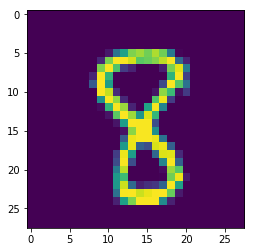

In [200]:
plt.imshow(xb[1].view(28,28))

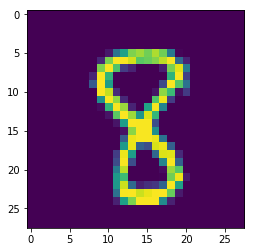

In [201]:
plt.imshow(xb1[1].view(28,28))

In [0]:
model, opt  = get_model()

In [0]:
def fit():
  for epoch in range(epochs):
    for xb, yb in train_dl:
      pred = model(xb)
      loss = loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()

In [0]:
fit()

In [205]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.1470, grad_fn=<NllLossBackward>), tensor(0.9375))

# Random Sampling

In [0]:
class Sampler():
  def __init__(self, ds, bs, shuffle=False):
    self.n, self.bs, self.shuffle = len(ds), bs, shuffle
  
  def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

In [210]:
s  = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [212]:
s = Sampler(small_ds, 3, True) 
[o for o in s]

[tensor([0, 1, 6]), tensor([8, 5, 7]), tensor([2, 4, 3]), tensor([9])]

In [0]:
def collate(b):
  xs, ys = zip(*b)
  return torch.stack(xs), torch.stack(ys)

class DataLoader():
  def __init__(self, ds, sampler, collate_fn=collate):
    self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
  
  def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

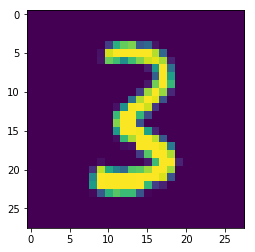

In [217]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(4)

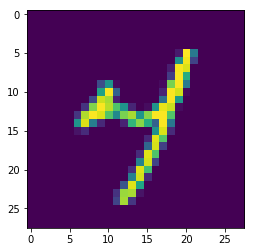

In [218]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

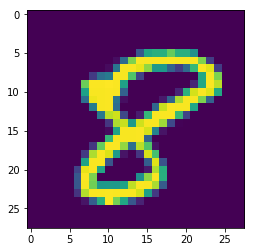

In [219]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [220]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2121, grad_fn=<NllLossBackward>), tensor(0.9062))

# PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [223]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1225, grad_fn=<NllLossBackward>), tensor(0.9531))

In [0]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [225]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2279, grad_fn=<NllLossBackward>), tensor(0.9219))

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [229]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.3233) tensor(0.9001)
1 tensor(0.1385) tensor(0.9593)
2 tensor(0.1115) tensor(0.9676)
3 tensor(0.1319) tensor(0.9606)
4 tensor(0.1144) tensor(0.9678)
